# Experiment 10 - Implementing a Bidirectional Encoder Representation with Transformers (BERT) for 

## About the BERT
BERT stands for "Bidirectional Encoder Representation with Transformers". To put it in simple words BERT extracts patterns or representations from the data or word embeddings by passing it through an encoder. The encoder itself is a transformer architecture that is stacked together. It is a bidirectional transformer which means that during training it considers the context from both left and right of the vocabulary to extract patterns or representations.

![](./assets/images/BERT-encoder.webp)

## Paradigms of Use
BERT uses two training paradigms: Pre-training and Fine-tuning. 

During pre-training, the model is trained on a large dataset to extract patterns. This is generally an unsupervised learning task where the model is trained on an unlabelled dataset like the data from a big corpus like Wikipedia.  

During fine-tuning the model is trained for downstream tasks like Classification, Text-Generation, Language Translation, Question-Answering, and so forth. Essentially, you can download a pre-trained model and then Transfer-learn the model on your data.

## How does BERT work?
BERT makes use of Transformer, an attention mechanism that learns contextual relations between words (or sub-words) in a text. In its vanilla form, Transformer includes two separate mechanisms — an encoder that reads the text input and a decoder that produces a prediction for the task. Since BERT’s goal is to generate a language model, only the encoder mechanism is necessary. The detailed workings of Transformer are described in a paper by Google.

As opposed to directional models, which read the text input sequentially (left-to-right or right-to-left), the Transformer encoder reads the entire sequence of words at once. Therefore it is considered bidirectional, though it would be more accurate to say that it’s non-directional. This characteristic allows the model to learn the context of a word based on all of its surroundings (left and right of the word).

When training language models, there is a challenge of defining a prediction goal. Many models predict the next word in a sequence (e.g. “The child came home from ___”), a directional approach which inherently limits context learning. To overcome this challenge, BERT uses two training strategies:

### Masked LM (MLM)

Before feeding word sequences into BERT, 15% of the words in each sequence are replaced with a [MASK] token. The model then attempts to predict the original value of the masked words, based on the context provided by the other, non-masked, words in the sequence. In technical terms, the prediction of the output words requires:
1. Adding a classification layer on top of the encoder output.
2. Multiplying the output vectors by the embedding matrix, transforming them into the vocabulary dimension.
3. Calculating the probability of each word in the vocabulary with softmax.

![](./assets/images/BERT-architecture.webp)

The BERT loss function takes into consideration only the prediction of the masked values and ignores the prediction of the non-masked words. As a consequence, the model converges slower than directional models, a characteristic which is offset by its increased context awareness.

### Next Sentence Prediction (NSP)

In the BERT training process, the model receives pairs of sentences as input and learns to predict if the second sentence in the pair is the subsequent sentence in the original document. During training, 50% of the inputs are a pair in which the second sentence is the subsequent sentence in the original document, while in the other 50% a random sentence from the corpus is chosen as the second sentence. The assumption is that the random sentence will be disconnected from the first sentence.

To help the model distinguish between the two sentences in training, the input is processed in the following way before entering the model:

1. A [CLS] token is inserted at the beginning of the first sentence and a [SEP] token is inserted at the end of each sentence.
2. A sentence embedding indicating Sentence A or Sentence B is added to each token. Sentence embeddings are similar in concept to token embeddings with a vocabulary of 2.
3. A positional embedding is added to each token to indicate its position in the sequence. The concept and implementation of positional embedding are presented in the Transformer paper.

![](./assets/images/BERT-with-modifications.webp)

Source: BERT [Devlin et al., 2018], with modifications

To predict if the second sentence is indeed connected to the first, the following steps are performed:

1. The entire input sequence goes through the Transformer model.
2. The output of the [CLS] token is transformed into a 2×1 shaped vector, using a simple classification layer (learned matrices of weights and biases).
3. Calculating the probability of IsNextSequence with softmax.

When training the BERT model, Masked LM and Next Sentence Prediction are trained together, with the goal of minimizing the combined loss function of the two strategies.

### Special tags for the tokens pre-defined by BERT
BERT takes special tokens during training. Here is a table explaining the purpose of various tokens:
|                                            Token                                            |                        Purpose                       |
|:-------------------------------------------------------------------------------------------:|:----------------------------------------------------:|
| [CLS]                                                                                       |       The first token is always classification       |
| [SEP]                                                                                       |                Separates two sentences               |
| [END]                                                                                       |                   End the sentence.                  |
| [PAD]                                                                                       |    Use to truncate the sentence with equal length.   |
|                                            [MASK]                                           | Use to create a mask by replacing the original word. |

## How to use BERT (Fine-tuning)

Using BERT for a specific task is relatively straightforward:

BERT can be used for a wide variety of language tasks, while only adding a small layer to the core model:

1. Classification tasks such as sentiment analysis are done similarly to Next Sentence classification, by adding a classification layer on top of the Transformer output for the [CLS] token.
2. In Question Answering tasks (e.g. SQuAD v1.1), the software receives a question regarding a text sequence and is required to mark the answer in the sequence. Using BERT, a Q&A model can be trained by learning two extra vectors that mark the beginning and the end of the answer.
3. In Named Entity Recognition (NER), the software receives a text sequence and is required to mark the various types of entities (Person, Organization, Date, etc) that appear in the text. Using BERT, a NER model can be trained by feeding the output vector of each token into a classification layer that predicts the NER label.

In the fine-tuning training, most hyper-parameters stay the same as in BERT training.

## Summary

BERT falls into a self-supervised model. That means, it can generate inputs and labels from the raw corpus without being explicitly programmed by humans. Remember the data it is trained on is unstructured.

BERT was pre-trained with two specific tasks: Masked Language Model and Next sentence prediction. The former uses masked input like “the man [MASK] to the store” instead of “the man went to the store”. This restricts BERT to see the words next to it which allows it to learn bidirectional representations as much as possible making it much more flexible and reliable for several downstream tasks. The latter predicts whether the two sentences are contextually assigned to each other. 

![](./assets/images/BERT-overview.webp)

## Code

### Import Libraries

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

### Preprocessing

#### Import the Corpus of Raw Text

In [6]:
data = pd.read_csv(r"./assets/data/spam-data.csv")
data.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


#### Check the Way Labels are Distributed

In [9]:
data['label'].value_counts(normalize=True)

0    0.865937
1    0.134063
Name: label, dtype: float64

#### Plot the Bar Plot for the Distribution

<AxesSubplot: >

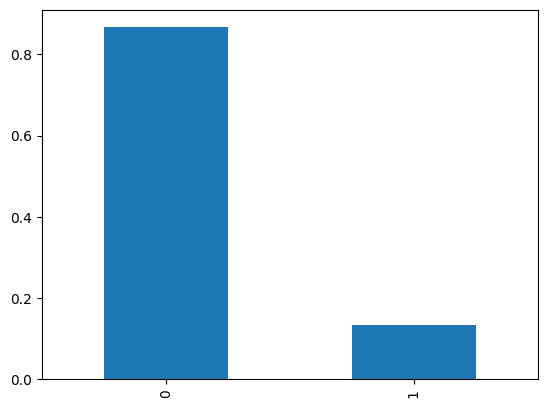

In [10]:
data['label'].value_counts(normalize=True).plot.bar()

### Split the Data into Training, Testing and Validation Sets

#### Train-test Split

In [11]:
XTrain, XTest, yTrain, yTest = train_test_split(data['text'], data['label'], random_state=42, test_size=0.3, stratify=data['label'])

#### Validation Split

In [12]:
XTrainValidation, XTestValidation, yTrainValidation, yTestValidation = train_test_split(XTest, yTest, random_state=42, test_size=0.5, stratify=yTest)

### Download and Import the Pre-trained BERT Model from Huggingface

In [15]:
# Import the BERT-base pretrained model
BERT = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

KeyboardInterrupt: 

### Get the Length of each Sequence of Text and Plot their Distributions

In [ ]:
# get length of all the messages in the train set
sequenceLength = [len(sample.split()) for sample in XTrain]

pd.Series(sequenceLength).hist(bins = 30)